In [23]:
from Base_Strategy import BaseStrategy

# --- NEW Mean Reversion Correlation Strategy ---

class MeanReversionCorrelationStrategy(BaseStrategy):
    """
    A mean reversion strategy that trades a pair of assets based on their
    rolling price correlation.
    """
    def __init__(self, name: str, symbols: List[str], **kwargs):
        if len(symbols) != 2:
            raise ValueError("MeanReversionCorrelationStrategy requires exactly two symbols.")
        # Initialize the base class with a composite name for the symbol
        super().__init__(name, symbol=f"{symbols[0]}-{symbols[1]}", **kwargs)
        self.symbols = symbols
    
    def load_data(self, start_date: str = '2016-01-01', interval: str = '1d') -> pd.DataFrame:
        """
        Overrides the base method to load and combine data for two assets,
        ensuring proper index alignment.
        """
        print(f"Loading data for symbols: {self.symbols}")
        s1, s2 = self.symbols[0], self.symbols[1]

        # Download data for both symbols
        s1_data = yf.download(s1, start=start_date, interval=interval)
        s2_data = yf.download(s2, start=start_date, interval=interval)

        if s1_data.empty or s2_data.empty:
            raise ValueError(
                f"No data downloaded for one or both symbols: {s1}, {s2}. "
                "Check ticker availability on Yahoo Finance for the requested date range."
            )

        # --- FINAL SOLUTION: Directly combine the 'Close' Series ---

        # 1. Extract the 'Close' price Series from each DataFrame
        s1_close = s1_data['Close']
        s2_close = s2_data['Close']

        # 2. Combine these two Series into a new DataFrame.
        #    - axis=1 places them side-by-side as columns.
        #    - join='inner' ensures we only keep dates where BOTH have a price.
        self.data = pd.concat([s1_close, s2_close], axis=1, join='inner')
        
        # 3. Rename the columns to their proper symbols.
        self.data.columns = self.symbols

        print(f"Data loaded and aligned. Shape of combined data: {self.data.shape}")

        return self.data

    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates the rolling correlation and windowed returns for the asset pair.
        """
        print("Calculating strategy indicators...")
        s1, s2 = self.symbols[0], self.symbols[1]
        
        # Get config parameters or use defaults
        rolling_window = self.config.get('rolling_window', 30)
        
        # Calculate daily returns
        s1_returns = df[s1].pct_change()
        s2_returns = df[s2].pct_change()
        
        # Calculate rolling correlation
        df['Rolling_Corr'] = s1_returns.rolling(window=rolling_window).corr(s2_returns).ffill()
        
        # Calculate windowed returns to identify the lagging asset
        df[f'{s1}_Window_Return'] = df[s1].pct_change(periods=rolling_window)
        df[f'{s2}_Window_Return'] = df[s2].pct_change(periods=rolling_window)
        
        return df.dropna()

    def generate_signals(self, df: pd.DataFrame) -> tuple:
        """
        Generates entry signals when correlation is low and one asset is lagging,
        and exit signals when correlation reverts to a high level.
        """
        print("Generating trading signals...")
        s1, s2 = self.symbols[0], self.symbols[1]

        # Get config parameters or use defaults
        entry_corr_low = self.config.get('entry_corr_low', 0.6)
        exit_corr_high = self.config.get('exit_corr_high', 0.9)

        # Use .shift(1) to prevent lookahead bias
        prev_corr = df['Rolling_Corr'].shift(1)
        s1_prev_ret = df[f'{s1}_Window_Return'].shift(1)
        s2_prev_ret = df[f'{s2}_Window_Return'].shift(1)

        # Entry conditions
        is_low_corr = (prev_corr < entry_corr_low)
        s1_is_lagging = (s1_prev_ret < s2_prev_ret)
        s2_is_lagging = (s2_prev_ret < s1_prev_ret)

        # Generate entry signals
        entries_s1 = is_low_corr & s1_is_lagging
        entries_s2 = is_low_corr & s2_is_lagging
        entries = pd.DataFrame({s1: entries_s1, s2: entries_s2}).fillna(False)

        # Exit condition (reversion to high correlation)
        is_high_corr = df['Rolling_Corr'] > exit_corr_high
        exits = pd.DataFrame({s1: is_high_corr, s2: is_high_corr}).fillna(False)

        # This is a long-only strategy
        short_entries = pd.DataFrame(False, index=df.index, columns=self.symbols)
        short_exits = pd.DataFrame(False, index=df.index, columns=self.symbols)

        return entries, exits, short_entries, short_exits
    
    def backtest(self, init_cash: float = 100000, fees: float = 0.001, **kwargs):
        """
        Overrides the base method to correctly handle multi-asset price data.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")

        df_with_indicators = self.calculate_indicators(self.data.copy())
        entries, exits, short_entries, short_exits = self.generate_signals(df_with_indicators)

        # The price data must have the same index as the signals.
        # df_with_indicators was returned by calculate_indicators and then used
        # to generate signals, so it's already perfectly aligned.
        price_data = df_with_indicators[self.symbols]

        # --- SOLUTION: REMOVED the explicit alignment block ---
        # The vbt.Portfolio.from_signals function handles alignment automatically.

        self.portfolio = vbt.Portfolio.from_signals(
            price_data,
            entries=entries,
            exits=exits,
            short_entries=short_entries,
            short_exits=short_exits,
            freq='1D',
            init_cash=init_cash,
            fees=fees,
            **kwargs
        )
        return self.portfolio

    def plot_results(self):
        """
        Overrides the base method to handle plotting for a multi-asset portfolio.
        """
        if self.portfolio is None:
            raise ValueError("Portfolio not created. Run backtest() first.")

        # Plot the results for each asset individually
        for symbol in self.symbols:
            print(f"\nGenerating portfolio plot for {symbol}...")
            fig = self.portfolio.plot(column=symbol)
            fig.update_layout(title=f"{self.name} - {symbol} Backtest Results")
            fig.show()
        



Loading data for symbols: ['CL=F', 'BZ=F']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Python_Folder\pyproj\Base_Strategy.py:80: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000002F3D2774EA0>. Pass column to select a single column/group.



Data loaded and aligned. Shape of combined data: (2384, 2)
Calculating strategy indicators...
Generating trading signals...
strategy_name: Oil Correlation Reversion
symbol: CL=F-BZ=F
total_return: 166.7147900241124
annual_return: None
max_drawdown: 18.009956650472645
sharpe_ratio: 0.7642698032125493
win_rate: 100.0
total_trades: None
final_value: 266714.7900241124

Generating portfolio plot for CL=F...


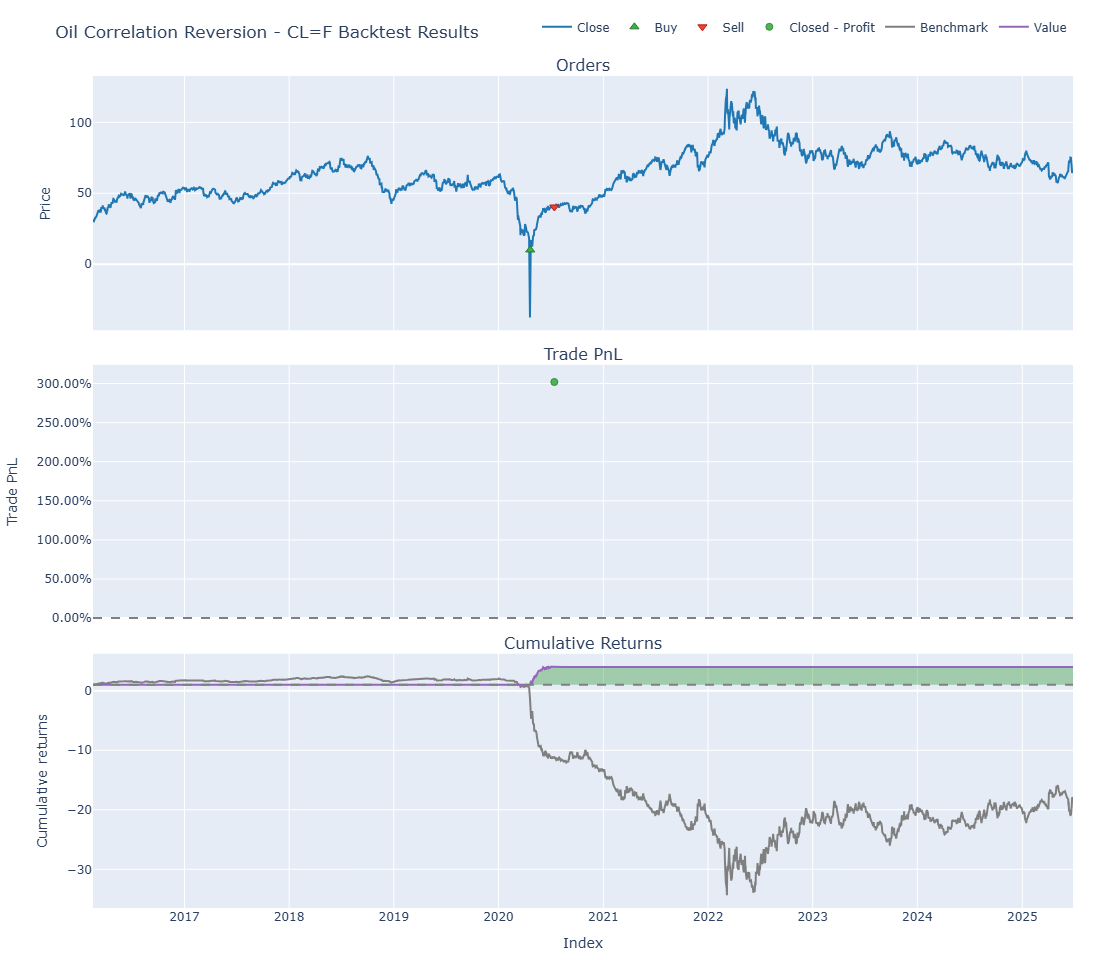


Generating portfolio plot for BZ=F...


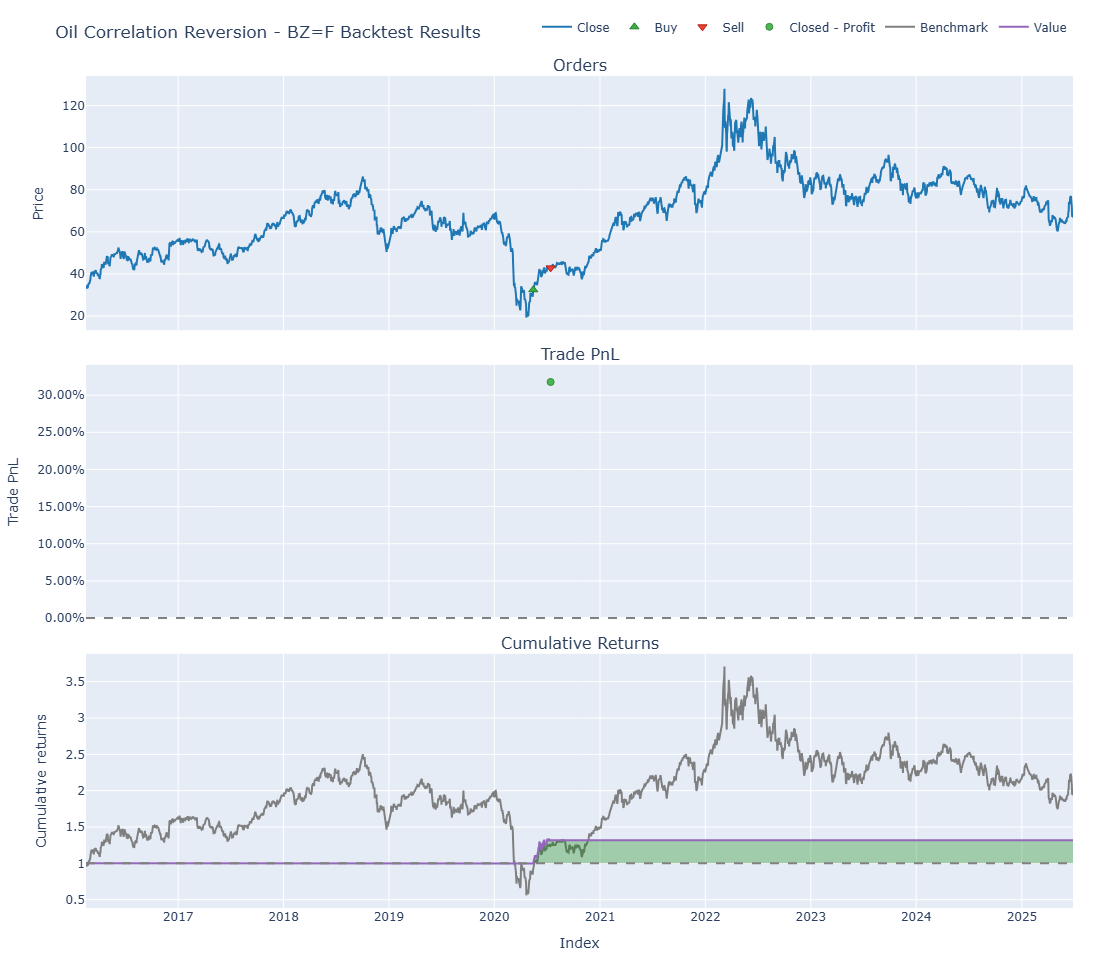

In [24]:
# --- Example Usage ---

# 1. Define strategy parameters
strategy_params = {
    'rolling_window': 30,
    'entry_corr_low': 0.6,
    'exit_corr_high': 0.9
}

# 2. Instantiate the strategy
mrc_strategy = MeanReversionCorrelationStrategy(
    name="Oil Correlation Reversion",
    symbols=['CL=F', 'BZ=F'],
    **strategy_params
)

# 3. Load data
mrc_strategy.load_data(start_date='2016-01-01')

# 4. Run the backtest
# You can override init_cash or fees here if needed
mrc_strategy.backtest(init_cash=100000)

# 5. Get and print performance metrics
metrics = mrc_strategy.get_performance_metrics()
for key, value in metrics.items():
    if key != 'portfolio': # Don't print the giant portfolio object
        print(f"{key}: {value}")

# 6. Plot the results
mrc_strategy.plot_results()